download datasets library

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
# install all required libraries
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay


In [ ]:
# install all required libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datasets import load_dataset
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer, DataCollatorWithPadding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# install all required libraries
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#loading testing 1k and training 10k records from amazon polarity dataset using huggingface transformer library
training = load_dataset('amazon_polarity', split='train[:10000]')
testing = load_dataset('amazon_polarity', split='test[:1000]')

**Preprocessing**

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
# preprocess the extracted daatset from amazon polarity (tokenization, stopword removal, filtering, lemmatization)
def preprocess_text(review_text):
    review_text = review_text.lower()
    review_text = re.sub('[^0-9a-zA-Z]', ' ', review_text)

    tokens = word_tokenize(review_text)
    stopword_set = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stopword_set]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    cleaned_text = ' '.join(lemmatized_tokens)
    return cleaned_text


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.DataFrame({'Text': training['content'], 'Label': training['label']})
df['Text'] = df['Text'].apply(preprocess_text)
texts = df['Text'].tolist()
labels = df['Label'].tolist()

In [ ]:
#print the data
df.head()

,Text,Label
0,sound track beautiful paint senery mind well w...,1
1,reading lot review saying best game soundtrack...,1
2,soundtrack favorite music time hand intense sa...,1
3,truly like soundtrack enjoy video game music p...,1
4,played game know divine music every single son...,1


**Training and testing lstm model**

In [ ]:
# need to set few paarmeters which will be used later in the training process
vocab_size_limit = 25500
max_sequence_length = 100
truncation_method = 'post'
padding_method = 'post'
unknown_token = ''
embedding_dimensions = 25

#preprocessing training and test data
processed_train_texts = [preprocess_text(sentence) for sentence in training['content']]
processed_test_texts = [preprocess_text(sentence) for sentence in testing['content']]
#tokenization
tokenizer = Tokenizer(num_words=vocab_size_limit, oov_token=unknown_token)
tokenizer.fit_on_texts(processed_train_texts)
#convert text into sequences
train_sequences = tokenizer.texts_to_sequences(processed_train_texts)
test_sequences = tokenizer.texts_to_sequences(processed_test_texts)

train_features = pad_sequences(train_sequences, maxlen=max_sequence_length, padding=padding_method, truncating=truncation_method)
test_features = pad_sequences(test_sequences, maxlen=max_sequence_length, padding=padding_method, truncating=truncation_method)
#convert into numpy array
train_labels_array = np.array(training['label'])
test_labels_array = np.array(testing['label'])
train_features = np.array(train_features)
test_features = np.array(test_features)
#embedding using glove model

embedding_lookup = dict()
with open('/content/glove.twitter.27B.25d.txt') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_lookup[word] = vector

embedding_matrix = np.zeros((vocab_size_limit, embedding_dimensions))
for word, index in tokenizer.word_index.items():
    if index >= vocab_size_limit:
        continue
    embedding_vector = embedding_lookup.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


batch_size_value = 64
epoch_count = 3
total_train_steps = len(train_features) // batch_size_value * epoch_count

learning_rate_schedule = PolynomialDecay(
    initial_learning_rate=1e-8,
    end_learning_rate=1e-3,
    decay_steps=total_train_steps
)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

# lstm model building
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size_limit, embedding_dimensions,
        weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=adam_optimizer,
    metrics=['accuracy']
)


early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('lstm_model.h5', monitor='val_loss', save_best_only=True)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

#training the model
training_history = lstm_model.fit(
    train_features,
    train_labels_array,
    validation_data=(test_features, test_labels_array),
    epochs=20,
    batch_size=batch_size_value,
    callbacks=[early_stop_callback, checkpoint_callback, tensorboard_callback]
)

#testing the model
best_lstm_model = tf.keras.models.load_model('lstm_model.h5')
test_loss, test_accuracy = best_lstm_model.evaluate(test_features, test_labels_array)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

#getting classification report
from sklearn.metrics import classification_report
predicted_probabilities = best_lstm_model.predict(test_features)
predicted_labels = (predicted_probabilities > 0.5).astype("int32").flatten()
print("\nClassification Report:")
print(classification_report(test_labels_array, predicted_labels, target_names=["Negative", "Positive"]))



Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5539 - loss: 0.6762

157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5543 - loss: 0.6760 - val_accuracy: 0.6690 - val_loss: 0.6172
Epoch 2/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6910 - loss: 0.5866

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6910 - loss: 0.5866 - val_accuracy: 0.7000 - val_loss: 0.5866
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7034 - loss: 0.5807

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7034 - loss: 0.5807 - val_accuracy: 0.7200 - val_loss: 0.5521
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7251 - loss: 0.5423 - val_accuracy: 0.7310 - val_loss: 0.5536
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7388 - loss: 0.5268

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7388 - loss: 0.5267 - val_accuracy: 0.7570 - val_loss: 0.5067
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7597 - loss: 0.5007

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7598 - loss: 0.5007 - val_accuracy: 0.7680 - val_loss: 0.4932
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7692 - loss: 0.4809

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7693 - loss: 0.4809 - val_accuracy: 0.7830 - val_loss: 0.4662
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7749 - loss: 0.4779 - val_accuracy: 0.7810 - val_loss: 0.4779
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7861 - loss: 0.4602 - val_accuracy: 0.7650 - val_loss: 0.4920
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8020 - loss: 0.4346

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8021 - loss: 0.4346 - val_accuracy: 0.7950 - val_loss: 0.4575
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8006 - loss: 0.4364 - val_accuracy: 0.7800 - val_loss: 0.4712
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8161 - loss: 0.4030 - val_accuracy: 0.7890 - val_loss: 0.4618
Epoch 13/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8344 - loss: 0.3803

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8344 - loss: 0.3804 - val_accuracy: 0.7920 - val_loss: 0.4466
Epoch 14/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8405 - loss: 0.3615 - val_accuracy: 0.7840 - val_loss: 0.4748
Epoch 15/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8657 - loss: 0.3261 - val_accuracy: 0.7870 - val_loss: 0.5015
Epoch 16/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8679 - loss: 0.3071 - val_accuracy: 0.7890 - val_loss: 0.4901
Epoch 17/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8910 - loss: 0.2736 - val_accuracy: 0.7790 - val_loss: 0.5148
Epoch 18/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9004 - loss: 0.2447 - val_accuracy: 0.7720 - val_loss: 0.5681


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7880 - loss: 0.4434
Test Accuracy: 79.20%
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.81      0.79       498
    Positive       0.80      0.78      0.79       502

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



**Visualization via graphs**

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


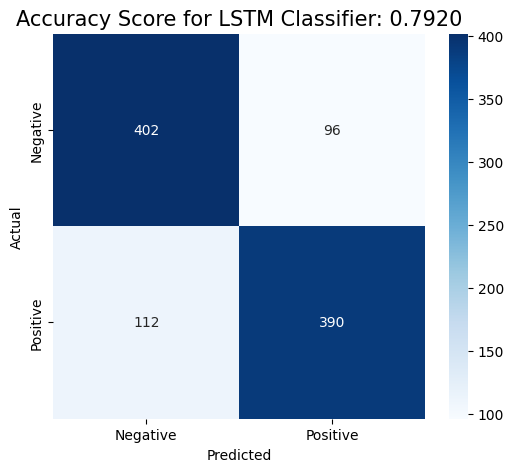

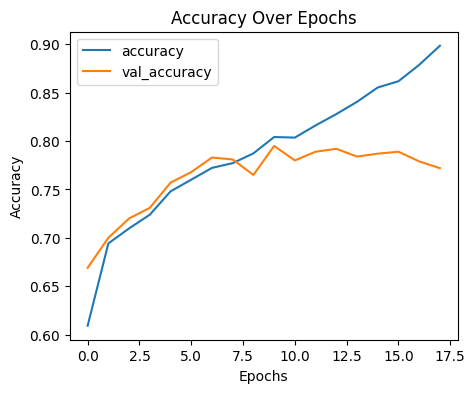

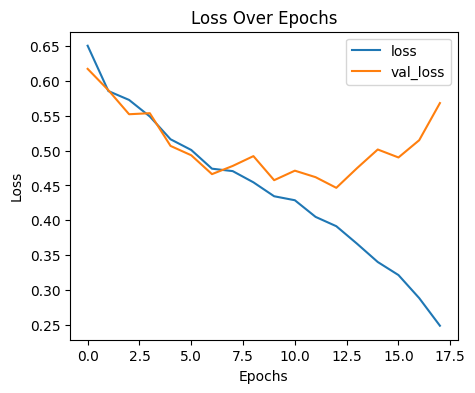

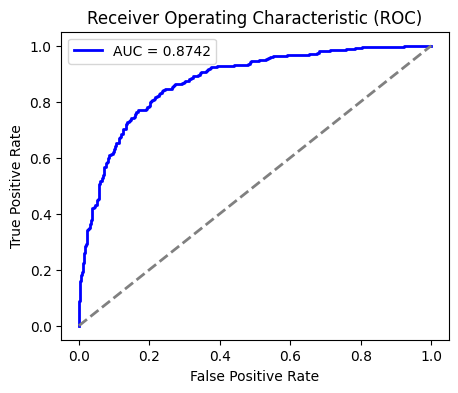

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

predicted_probabilities = best_lstm_model.predict(test_features)
predicted_classes = (predicted_probabilities >= 0.5).astype(int)
#getting confusion matrix
conf_matrix = confusion_matrix(test_labels_array, predicted_classes)
label_names = ["Negative", "Positive"]
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
conf_matrix_title = f'Accuracy Score for LSTM Classifier: {test_accuracy:.4f}'
plt.title(conf_matrix_title, size=15)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#method to plot graph
def plot_training_graphs(history_object, metric_name):
    plt.figure(figsize=(5, 4))
    plt.plot(history_object.history[metric_name])
    plt.plot(history_object.history['val_' + metric_name])
    plt.xlabel("Epochs")
    plt.ylabel(metric_name.capitalize())
    plt.legend([metric_name, 'val_' + metric_name])
    plt.title(f'{metric_name.capitalize()} Over Epochs')
    plt.show()
#getting training and loss curves
plot_training_graphs(training_history, "accuracy")
plot_training_graphs(training_history, "loss")

flattened_probs = predicted_probabilities.ravel()
false_pos_rate, true_pos_rate, threshold_vals = roc_curve(test_labels_array, flattened_probs)
roc_auc_score = auc(false_pos_rate, true_pos_rate)

plt.figure(figsize=(5, 4))
plt.plot(false_pos_rate, true_pos_rate, color='blue', lw=2,
         label='AUC = {:.4f}'.format(roc_auc_score))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()
